In [43]:
import numpy as np
import scipy
import numpy 
import matplotlib.pyplot as plt
from scipy import linalg, special, stats
from numpy import genfromtxt
import ML_support as ml

In [44]:
class GaussianClassifier:
    def __init__(self):
        self.C = {}
        self.mu = {}

    def train(self, DTR, LTR):
        self.mu, self.C = ml.MU_Cov_calculator(DTR, LTR)

    def test(self, DTE, LTE):
        S = numpy.zeros((numpy.unique(LTE).size, DTE.shape[1]))
        predicted = []

        for i in numpy.unique(LTE):
            S[i, :] = ml.GAU_logpdf_ND(DTE, self.mu[i], self.C[i]) + numpy.log(1 / 2)

        Sp = scipy.special.logsumexp(S, axis=0)

        for x, p in zip(S.T, Sp): 
            tmp = x - p
            predicted.append(numpy.argmax(tmp))

        predicted = numpy.array(predicted)

        True_prediction = numpy.array([predicted == LTE])

        error = 1 - (numpy.count_nonzero(True_prediction) / True_prediction.size)

        print("Gaussian Classifier error:", error)
        return error

In [45]:
Data, labels = ml.loadFile('../Train.txt')

In [46]:
(DTR, LTR), (DTE,LTE) = ml.split_db_2to1(Data, labels, seed=42)

In [5]:
G=GaussianClassifier()
G.train(DTR,LTR)
G.test(DTE,LTE)

Gaussian Classifier error: 0.040644944575075614


In [6]:
Gn=GaussianClassifier()
Gn.train(ml.z_normalization(DTR), LTR)
Gn.test(DTE, LTE)
Gn.test(ml.z_normalization(DTE), LTE)

Gaussian Classifier error: 0.04165267047363119
Gaussian Classifier error: 0.04266039637218677


In [7]:
GG=GaussianClassifier()
GG.train(ml.gaussianize(DTR), LTR)
GG.test(DTE, LTE)
GG.test(ml.gaussianize(DTE), LTE)

Gaussian Classifier error: 0.0923748740342627
Gaussian Classifier error: 0.08296943231441045


In [47]:
class GaussianClassifier_mod1:
    def __init__(self):
        self.C = {}
        self.mu = {}

    def train(self, DTR, LTR):
        self.mu, self.C = ml.MU_Cov_calculator(DTR, LTR)

    def test(self, DTE, LTE, app, ROC=False):
        S = numpy.zeros((numpy.unique(LTE).size, DTE.shape[1]))
        ll = numpy.zeros((numpy.unique(LTE).size, DTE.shape[1]))
        predicted = []

        for i in numpy.unique(LTE):
            ll[i, :] = ml.GAU_logpdf_ND(DTE, self.mu[i], self.C[i])
        
        llr = numpy.array(ll[1, :]-ll[0, :])
        
        CM = ml.compute_optimal_B_decision(app, llr, LTE)
        sensitivity = (1-ml.compute_FNR(CM)) # TPR
        specificity = (1-ml.compute_FPR(CM)) # TNR
        
        app_bayes_risk=ml.compute_Bayes_risk(CM, app)
        DCF = ml.compute_norm_Bayes(app_bayes_risk, app)
        
        minDCF= ml.compute_min_DCF(llr, app, LTE)
        error = 1-(CM[0, 0]+CM[1,1])/(len(LTE))
        if(ROC == True):
            ml.plot_ROC(app, llr, LTE)
        
        print("\-/ \-/ \-/ \-/ \-/ ")
        print("Gaussian Classifier error:", error)
        print(app,"DCF:", DCF, "minDCF:", minDCF)
        print('Sensitivity (TPR):', sensitivity, ' Specificity (TNR): ', specificity)
        print('CM\n', CM)
        print("/-\ /-\ /-\ /-\ /-\ ")
        return error
       

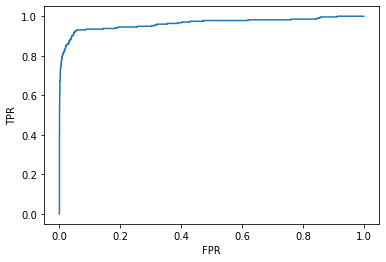

\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.040644944575075614
[0.5, 1, 1] DCF: 0.16563353744700895 minDCF: 0.1256510329049189
Sensitivity (TPR): 0.8654545454545455  Specificity (TNR):  0.9689119170984456
CM
 [[2618.   37.]
 [  84.  238.]]
/-\ /-\ /-\ /-\ /-\ 


0.040644944575075614

In [48]:
G=GaussianClassifier_mod1()
G.train(DTR,LTR)
G.test(DTE,LTE, [1/2,1,1], True)

In [49]:
G.test(DTE,LTE, [0.1,1,1])

\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.03325495465233452
[0.1, 1, 1] DCF: 0.34258663616176577 minDCF: 0.28024628221519415
Sensitivity (TPR): 0.8472727272727273  Specificity (TNR):  0.9789045151739453
CM
 [[2645.   42.]
 [  57.  233.]]
/-\ /-\ /-\ /-\ /-\ 


0.03325495465233452

In [50]:
G.test(DTE,LTE, [0.9,1,1])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.04702720859926102
[0.9, 1, 1] DCF: 0.9254572370634548 minDCF: 0.6584025301123747
Sensitivity (TPR): 0.9018181818181819  Specificity (TNR):  0.9581791265729089
CM
 [[2589.   27.]
 [ 113.  248.]]
/-\ /-\ /-\ /-\ /-\ 


0.04702720859926102

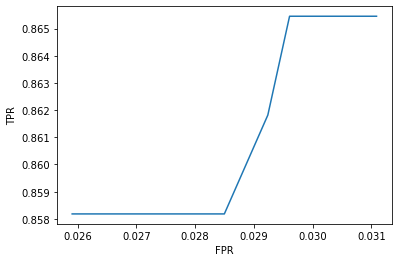

\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.04534766543500168
[0.5, 5, 1] DCF: 0.5843146490814884 minDCF: 0.4028194603324137
CM
 [[2597.   30.]
 [ 105.  245.]]
/-\ /-\ /-\ /-\ /-\ 


In [12]:
G.test(DTE,LTE, [0.5,5,1], True)


In [36]:
G.test(DTE,LTE, [0.2,1,5])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.0329190460194827
[0.2, 1, 5] DCF: 0.5559383621559787 minDCF: 0.32466994145750616
CM [[2649.   45.]
 [  53.  230.]]
/-\ /-\ /-\ /-\ /-\ 


In [37]:
G.test(DTE,LTE, [0.7,5,1])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.05005038629492775
[0.7, 5, 1] DCF: 1.148552138707579 minDCF: 0.7262813179911625
CM [[2579.   26.]
 [ 123.  249.]]
/-\ /-\ /-\ /-\ /-\ 


In [9]:
G.test(DTE,LTE, [0.9,10,1])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.09035942223715154
[0.9, 10, 1] DCF: 5.983803243388737 minDCF: 0.9130273871206513
CM
 [[2451.   18.]
 [ 251.  257.]]
/-\ /-\ /-\ /-\ /-\ 


In [10]:
G.test(DTE,LTE, [0.9,5,1])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.06953308700033589
[0.9, 5, 1] DCF: 3.1786689993943886 minDCF: 0.9130273871206513
CM
 [[2514.   19.]
 [ 188.  256.]]
/-\ /-\ /-\ /-\ /-\ 


In [11]:
G.test(DTE,LTE, [0.9,3,1])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.05844810211622442
[0.9, 3, 1] DCF: 2.020631182289214 minDCF: 0.9130273871206513
CM
 [[2548.   20.]
 [ 154.  255.]]
/-\ /-\ /-\ /-\ /-\ 


In [12]:
G.test(DTE,LTE, [0.8,5,1])


\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.05374538125629824
[0.8, 5, 1] DCF: 1.651073279052554 minDCF: 0.9086064194872486
CM
 [[2564.   22.]
 [ 138.  253.]]
/-\ /-\ /-\ /-\ /-\ 


In [27]:
class GaussianClassifier_mod2:
    def __init__(self):
        self.C = {}
        self.mu = {}

    def train(self, DTR, LTR):
        self.mu, self.C = ml.MU_Cov_calculator(DTR, LTR)

    def test(self, DTE, LTE):
        S = numpy.zeros((numpy.unique(LTE).size, DTE.shape[1]))
        ll = numpy.zeros((numpy.unique(LTE).size, DTE.shape[1]))
        predicted = []

        for i in numpy.unique(LTE):
            ll[i, :] = ml.GAU_logpdf_ND(DTE, self.mu[i], self.C[i])
        
        return list(ll[1, :]-ll[0, :])
        
        
       

In [34]:
def kfold(classifier, D, L, fold, app):
    error = 0
    N = int(D.shape[1]/fold) #numero di elementi per ogni fold
    numpy.random.seed(0) #imposto il seed del generatore di numeri casuali -> in tal modo genererò la stessa sequenza di numeri casuali aventi seed uguale
    indexes = numpy.random.permutation(D.shape[1]) #genero una sequenza di numeri casuali che vanno da 0 al num_di_campioni
    
    LTE_final = []
    llr_final = []
    for j in range(fold):
        test_indexes = indexes[(j*N):((j+1)*N)] #selezioni gli indici che identificano i campioni (casuali) del test set
        if(j > 0): #se il test set non è preso dalla prima fold (--> il test set è una fold intermedia o l'ultima fold)
            left_indexes = indexes[0:(j*N)] #allora prendo tutti gli indici che stanno a sinistra di tale fold
        else: #se il test set è preso dalla prima fold
            right_indexes = indexes[((j+1)*N):] #prendo tutti gli indici a destra della prima fold

        if(j == 0): #se il test set è preso dalla prima fold
            train_indexes = right_indexes #assegno agli indici di training quelli che stanno a destra della prima fold
        elif(j == fold-1): #se il test set è preso dall'ultima fold
            train_indexes = left_indexes #assegno agli indici di training quelli che stanno a sinistra dell'ultima fold
        else: #in questo caso il test set è preso da una fold intermedia
            train_indexes = numpy.hstack((left_indexes, right_indexes)) #pertanto assegno agli indici di training quelli appartenenti alle fold di sinistra e di destra

        DTR = D[:, train_indexes]  #definisco insieme di training e di testing
        LTR = L[train_indexes]
        DTE = D[:, test_indexes]
        LTE = L[test_indexes]
        LTE_final.extend(LTE)
        classifier.train(DTR, LTR)
        llr_final.extend(classifier.test(DTE, LTE))
        
    CM = ml.compute_optimal_B_decision(app, llr_final, LTE_final)
    sensitivity = (1-ml.compute_FNR(CM)) # TPR
    specificity = (1-ml.compute_FPR(CM)) # TNR
        
    app_bayes_risk=ml.compute_Bayes_risk(CM, app)
    DCF = ml.compute_norm_Bayes(app_bayes_risk, app)

    minDCF= ml.compute_min_DCF(llr_final, app, LTE_final)
    error = 1-(CM[0, 0]+CM[1,1])/(len(LTE_final))

    print("\-/ \-/ \-/ \-/ \-/ ")
    print("Gaussian Classifier error:", error)
    print(app,"DCF:", DCF, "minDCF:", minDCF)
    print('Sensitivity (TPR):', sensitivity, ' Specificity (TNR): ', specificity)
    print('CM\n', CM)
    print("/-\ /-\ /-\ /-\ /-\ ")

In [35]:
kg=GaussianClassifier_mod2()
kfold(kg, Data, labels, 5, [0.5, 1, 1])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.03899159663865548
[0.5, 1, 1] DCF: 0.16116189896750285 minDCF: 0.14089747412745154
Sensitivity: 0.8684531059683314  Specificity:  0.9703849950641659
CM
 [[7864.  108.]
 [ 240.  713.]]
/-\ /-\ /-\ /-\ /-\ 


In [36]:
kfold(kg, Data, labels, 5, [0.9, 1, 1])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.04974789915966382
[0.9, 1, 1] DCF: 0.9544119203100259 minDCF: 0.6624496647119722
Sensitivity: 0.8989037758830695  Specificity:  0.9554540967423495
CM
 [[7743.   83.]
 [ 361.  738.]]
/-\ /-\ /-\ /-\ /-\ 


In [37]:
kfold(kg, Data, labels, 5, [0.1, 1, 1])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.032717086834733844
[0.1, 1, 1] DCF: 0.33771731798435206 minDCF: 0.2812573270985111
Sensitivity: 0.8477466504263094  Specificity:  0.9793928923988154
CM
 [[7937.  125.]
 [ 167.  696.]]
/-\ /-\ /-\ /-\ /-\ 


In [38]:
kfold(kg, Data, labels, 5, [0.5, 10, 1])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.050308123249299674
[0.5, 10, 1] DCF: 1.0440682515844568 minDCF: 0.703862575796016
Sensitivity: 0.9001218026796589  Specificity:  0.9547137216189536
CM
 [[7737.   82.]
 [ 367.  739.]]
/-\ /-\ /-\ /-\ /-\ 


In [39]:
kfold(kg, Data, labels, 5, [0.5, 1, 10])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.0323809523809524
[0.5, 1, 10] DCF: 0.3546066182261538 minDCF: 0.2896282553359313
Sensitivity: 0.8465286236297198  Specificity:  0.9798864758144127
CM
 [[7941.  126.]
 [ 163.  695.]]
/-\ /-\ /-\ /-\ /-\ 


In [40]:
kfold(kg, Data, labels, 5, [0.9, 10, 1])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.10218487394957987
[0.9, 10, 1] DCF: 6.353980921588174 minDCF: 0.9842053307008884
Sensitivity: 0.9305724725943971  Specificity:  0.8944965449160909
CM
 [[7249.   57.]
 [ 855.  764.]]
/-\ /-\ /-\ /-\ /-\ 


In [41]:
kfold(kg, Data, labels, 5, [0.9, 1, 10])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.03843137254901963
[0.9, 1, 10] DCF: 0.1659287631343355 minDCF: 0.14694387096851766
Sensitivity: 0.8660170523751523  Specificity:  0.971248766041461
CM
 [[7871.  110.]
 [ 233.  711.]]
/-\ /-\ /-\ /-\ /-\ 


In [42]:
kfold(kg, Data, labels, 5, [0.9, 5, 1])

[8759 5514 1900 ... 4859 3264 2732]
\-/ \-/ \-/ \-/ \-/ 
Gaussian Classifier error: 0.07507002801120444
[0.9, 5, 1] DCF: 3.637382871633443 minDCF: 0.9842053307008884
Sensitivity: 0.9208282582216809  Specificity:  0.9253455083909181
CM
 [[7499.   65.]
 [ 605.  756.]]
/-\ /-\ /-\ /-\ /-\ 
